In [1]:
from lzma import LZMADecompressor, LZMAError, FORMAT_AUTO
from urllib import request
from urllib.error import HTTPError
import struct
from datetime import datetime, timedelta

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import statsmodels.api as sm

import pyximport
pyximport.install()

import lead_lag

# Below helpful procedures courtesy of terukusu https://github.com/terukusu/download-tick-from-dukascopy
def decompress_lzma(data):
    results = []
    len(data)
    while True:
        decomp = LZMADecompressor(FORMAT_AUTO, None, None)
        try:
            res = decomp.decompress(data)
        except LZMAError:
            if results:
                break
            else:
                raise
        results.append(res)
        data = decomp.unused_data
        if not data:
            break
        if not decomp.eof:
            raise LZMAError("Compressed data ended before the end-of-stream marker was reached")
    return b"".join(results)


def tokenize(buffer):
    token_size = 20
    token_count = int(len(buffer) / token_size)
    tokens = list(map(lambda x: struct.unpack_from('>3I2f', buffer, token_size * x), range(0, token_count)))
    return tokens


def normalize_tick(symbol, day, time, ask, bid, ask_vol, bid_vol):
    date = day + timedelta(milliseconds=time)

    # TODO 網羅する。この通過ペア以外も有るかも
    if any(map(lambda x: x in symbol.lower(), ['usdrub', 'xagusd', 'xauusd', 'jpy'])):
        point = 1000
    else:
        point = 100000

    return [date, ask/point, bid/point, round(ask_vol * 1000000), round(bid_vol * 1000000)]


def download_ticks(symbol, day, hours=(0, 24)):
    url_prefix='https://datafeed.dukascopy.com/datafeed'

    ticks_day = []
    for h in range(hours[0], hours[1]):
        file_name = f'{h:02d}h_ticks.bi5'
        url = f'{url_prefix}/{symbol}/{day.year:04d}/{day.month-1:02d}/{day.day:02d}/{file_name}'
        print(f'downloading: {url}')

        req = request.Request(url)
        try:
            with request.urlopen(req) as res:
                res_body = res.read()
        except HTTPError:
            print('download failed. continuing..')
            continue

        if len(res_body):
            try:
                data = decompress_lzma(res_body)
            except LZMAError:
                print('decompress failed. continuing..')
                continue
        else:
            data = []

        tokenized_data = tokenize(data)
        ticks_hour = list(map(lambda x: normalize_tick(symbol, day + timedelta(hours=h), *x), tokenized_data))
        ticks_day.extend(ticks_hour)

    return ticks_day


def format_to_csv_for_ticks(ticks):
    return '\n'.join(map(lambda x: '{},{},{},{},{}'.format(x[0].strftime('%Y-%m-%d %H:%M:%S.%f'), *x[1:]), ticks))+'\n'

In [2]:
def pearson_correlation(x, y):
    assert len(x) == len(y)
    x_centered = x - np.mean(x)
    y_centered = y - np.mean(y)
    r = np.sum(x_centered * y_centered)
    r /= np.sqrt(np.sum(x_centered ** 2) * np.sum(y_centered ** 2))
    return r

def ll_ratio(price_1, price_2, lags):
    lr_1 = np.diff(np.log(price_1))
    lr_2 = np.diff(np.log(price_2))
    cross_corr = [pearson_correlation(lr_1, lr_2)]
    for i in range(1, lags+1, 1):
        cross_corr.append(pearson_correlation(lr_1[i:], lr_2[:-i]))
        cross_corr.insert(0, pearson_correlation(lr_1[:-i], lr_2[i:]))
    llr = np.sum(np.array(cross_corr[:lags]) ** 2) / np.sum(np.array(cross_corr[lags+1:]) ** 2)
    return llr

def lead_lag_estimate(price_1, price_2, max_lag, corr=pearson_correlation):
    lr_1 = np.diff(np.log(price_1))
    lr_2 = np.diff(np.log(price_2))
    cross_corr = [corr(lr_1, lr_2)]
    for i in range(1, max_lag+1, 1):
        cross_corr.append(corr(lr_1[:-i], lr_2[i:]))
        cross_corr.insert(0, corr(lr_1[i:], lr_2[:-i]))
    llr = np.sum(np.array(cross_corr[max_lag+1:]) ** 2) / np.sum(np.array(cross_corr[:max_lag]) ** 2)
    return llr, cross_corr

def pearson_cross_correlation(price_1, price_2, max_lag):
    x = np.diff(np.log(price_1))
    y = np.diff(np.log(price_2))
    cross_corr = [pearson_correlation(x, y)]
    for i in range(1, max_lag+1, 1):
        cross_corr.append(pearson_correlation(x[:-i], y[i:]))
        cross_corr.insert(0, pearson_correlation(x[i:], y[:-i]))
    return cross_corr

def lead_lag_ratio(cross_corr):
    max_lag = int((len(cross_corr) - 1) / 2)
    return np.sum(np.array(cross_corr[max_lag+1:]) ** 2) / np.sum(np.array(cross_corr[:max_lag]) ** 2)

Import of One Trading Date of FX Tick Data

In [3]:
date = datetime.strptime('2025-08-29', '%Y-%m-%d')
trading_hours = (8, 18)  # Trading hours in UTC
ccies = ['USDJPY', 'USDZAR']

ticks = download_ticks(ccies[0], date, hours=trading_hours)
df_ticks = pd.DataFrame(ticks, columns=['datetime', 'ask', 'bid', 'ask_vol', 'bid_vol'])
df_ticks.set_index('datetime', inplace=True)
df_ticks['mid'] = (df_ticks['ask'] + df_ticks['bid']) / 2
ts1_ticks = df_ticks['mid'].copy()
ticks = download_ticks(ccies[1], date, hours=trading_hours)
df_ticks = pd.DataFrame(ticks, columns=['datetime', 'ask', 'bid', 'ask_vol', 'bid_vol'])
df_ticks.set_index('datetime', inplace=True)
df_ticks['mid'] = (df_ticks['ask'] + df_ticks['bid']) / 2
ts2_ticks = df_ticks['mid'].copy()

del ticks
del df_ticks

# Drop ticks with no price change
ts1_ticks = ts1_ticks[(ts1_ticks != ts1_ticks.shift(1))]
ts2_ticks = ts2_ticks[(ts2_ticks != ts2_ticks.shift(1))]


downloading: https://datafeed.dukascopy.com/datafeed/USDJPY/2025/07/29/08h_ticks.bi5
downloading: https://datafeed.dukascopy.com/datafeed/USDJPY/2025/07/29/09h_ticks.bi5
downloading: https://datafeed.dukascopy.com/datafeed/USDJPY/2025/07/29/10h_ticks.bi5
downloading: https://datafeed.dukascopy.com/datafeed/USDJPY/2025/07/29/11h_ticks.bi5
downloading: https://datafeed.dukascopy.com/datafeed/USDJPY/2025/07/29/12h_ticks.bi5
downloading: https://datafeed.dukascopy.com/datafeed/USDJPY/2025/07/29/13h_ticks.bi5
downloading: https://datafeed.dukascopy.com/datafeed/USDJPY/2025/07/29/14h_ticks.bi5
downloading: https://datafeed.dukascopy.com/datafeed/USDJPY/2025/07/29/15h_ticks.bi5
downloading: https://datafeed.dukascopy.com/datafeed/USDJPY/2025/07/29/16h_ticks.bi5
downloading: https://datafeed.dukascopy.com/datafeed/USDJPY/2025/07/29/17h_ticks.bi5
downloading: https://datafeed.dukascopy.com/datafeed/USDZAR/2025/07/29/08h_ticks.bi5
downloading: https://datafeed.dukascopy.com/datafeed/USDZAR/2025/

Epps Effect and Hayashi-Yoshida Estimator

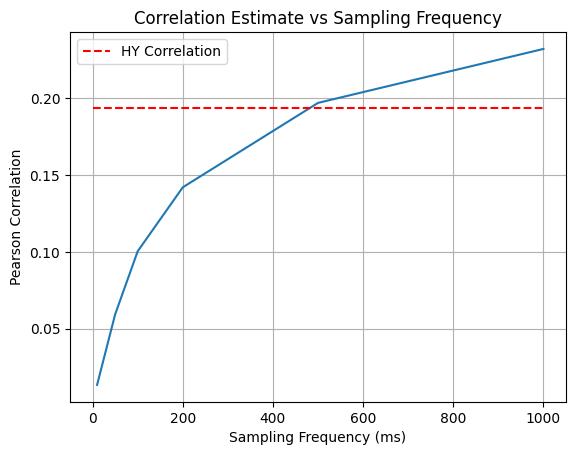

In [4]:
freqs = [10, 50, 100, 200, 500, 1000]
corellation_results = []

for freq in freqs:
    sampling = str(freq) + 'ms'
    ts1 = ts1_ticks.resample(sampling).last().ffill()
    ts2 = ts2_ticks.resample(sampling).last().ffill()
    df_sampled = pd.DataFrame({'ts1': ts1, 'ts2': ts2}).dropna()
    corellation_results.append(pearson_correlation(np.diff(np.log(df_sampled['ts1'])), np.diff(np.log(df_sampled['ts2']))))

ll = lead_lag.LeadLag(
    ts1=np.log(ts1_ticks),
    ts2=np.log(ts2_ticks),
    max_lag=1,  # [-X seconds, +X seconds]
    verbose=False,
    min_precision=0.01
)
ll.run_inference(num_threads=1)

plt.plot(freqs, corellation_results)
plt.hlines(y=ll.contrasts[100], xmax=1000, xmin=0, color='r', linestyle='--', label='HY Correlation')
plt.xlabel('Sampling Frequency (ms)')
plt.ylabel('Pearson Correlation')
plt.title('Correlation Estimate vs Sampling Frequency')
plt.grid()
plt.legend()
plt.show()

Cross Correlation Lead-Lag Inference and Lead-Lag Ratio

Lead-Lag Ratio: 3.3045
Lag at Max Correlation: 20.0 ms


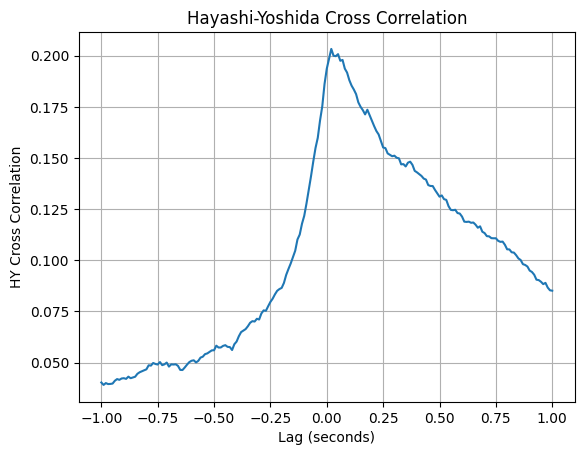

In [5]:
hy_cross_corr = ll.contrasts
print(f'Lead-Lag Ratio: {lead_lag_ratio(hy_cross_corr):.4f}')
print(f'Lag at Max Correlation: {ll.lag_range[np.argmax(hy_cross_corr)] * ll.precision * 1000} ms')

plt.plot(ll.lag_range * ll.precision, hy_cross_corr)
plt.xlabel('Lag (seconds)')
plt.ylabel('HY Cross Correlation')
plt.title('Hayashi-Yoshida Cross Correlation')
plt.grid()
plt.show()

Average Cross Corrlation and Lead-Lag Ratio for period

downloading: https://datafeed.dukascopy.com/datafeed/USDJPY/2025/07/01/08h_ticks.bi5


downloading: https://datafeed.dukascopy.com/datafeed/USDJPY/2025/07/01/09h_ticks.bi5
downloading: https://datafeed.dukascopy.com/datafeed/USDJPY/2025/07/01/10h_ticks.bi5
downloading: https://datafeed.dukascopy.com/datafeed/USDJPY/2025/07/01/11h_ticks.bi5
downloading: https://datafeed.dukascopy.com/datafeed/USDJPY/2025/07/01/12h_ticks.bi5
downloading: https://datafeed.dukascopy.com/datafeed/USDJPY/2025/07/01/13h_ticks.bi5
downloading: https://datafeed.dukascopy.com/datafeed/USDJPY/2025/07/01/14h_ticks.bi5
downloading: https://datafeed.dukascopy.com/datafeed/USDJPY/2025/07/01/15h_ticks.bi5
downloading: https://datafeed.dukascopy.com/datafeed/USDJPY/2025/07/01/16h_ticks.bi5
downloading: https://datafeed.dukascopy.com/datafeed/USDJPY/2025/07/01/17h_ticks.bi5
downloading: https://datafeed.dukascopy.com/datafeed/USDZAR/2025/07/01/08h_ticks.bi5
downloading: https://datafeed.dukascopy.com/datafeed/USDZAR/2025/07/01/09h_ticks.bi5
downloading: https://datafeed.dukascopy.com/datafeed/USDZAR/2025/

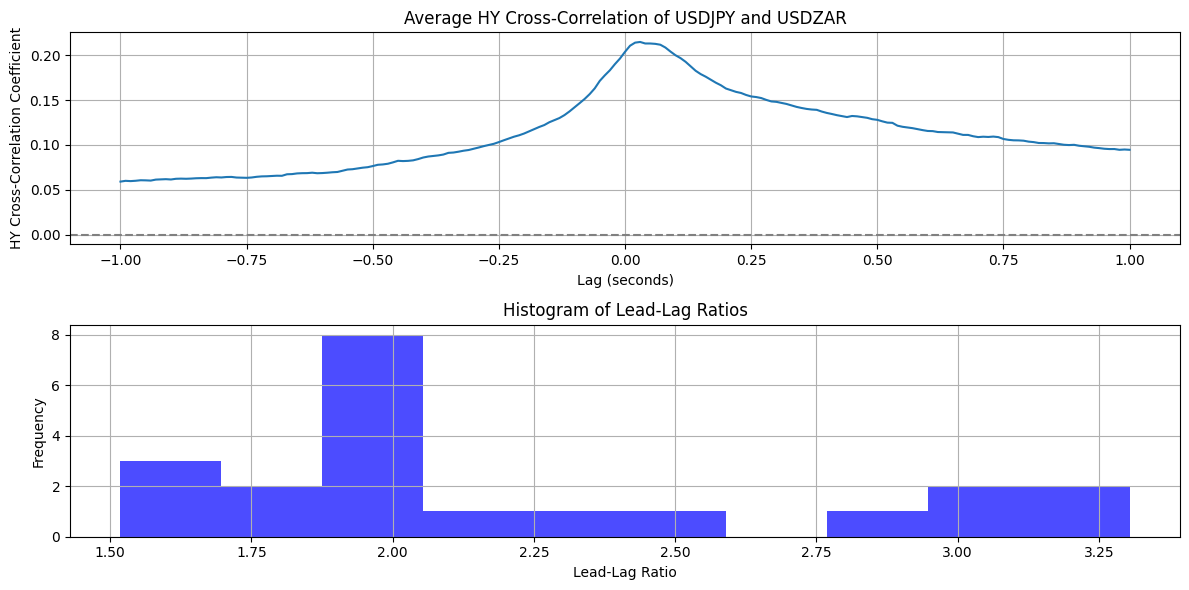

In [98]:
start_date = datetime.strptime('2025-08-01', '%Y-%m-%d')
end_date = datetime.strptime('2025-08-29', '%Y-%m-%d')
ccies = ['USDJPY', 'USDZAR']
date_range = pd.date_range(start=start_date, end=end_date, freq='B')
trading_hours = (8, 18)  # Trading hours in UTC

df_llr = pd.Series(index=date_range, dtype=float)
df_cross_corr = pd.DataFrame(index=date_range, columns=ll.lag_range * ll.precision, dtype=float)
for date in date_range:
    ticks = download_ticks(ccies[0], date, hours=trading_hours)
    df_ticks = pd.DataFrame(ticks, columns=['datetime', 'ask', 'bid', 'ask_vol', 'bid_vol'])
    df_ticks.set_index('datetime', inplace=True)
    df_ticks['mid'] = (df_ticks['ask'] + df_ticks['bid']) / 2
    ts1_ticks = df_ticks['mid'].copy()
    ticks = download_ticks(ccies[1], date, hours=trading_hours)
    df_ticks = pd.DataFrame(ticks, columns=['datetime', 'ask', 'bid', 'ask_vol', 'bid_vol'])
    df_ticks.set_index('datetime', inplace=True)
    df_ticks['mid'] = (df_ticks['ask'] + df_ticks['bid']) / 2
    ts2_ticks = df_ticks['mid'].copy()

    del ticks
    del df_ticks

    # Drop ticks with no price change
    ts1_ticks = ts1_ticks[(ts1_ticks != ts1_ticks.shift(1))]
    ts2_ticks = ts2_ticks[(ts2_ticks != ts2_ticks.shift(1))]

    ll = lead_lag.LeadLag(
        ts1=np.log(ts1_ticks),
        ts2=np.log(ts2_ticks),
        max_lag=1,  # [-X seconds, +X seconds]
        verbose=False,
        min_precision=0.01
    )
    ll.run_inference()
    df_llr[date] = lead_lag_ratio(ll.contrasts)
    df_cross_corr.loc[date] = ll.contrasts

fig, ax = plt.subplots(2, 1, figsize=(12, 6))
ax[0].plot(df_cross_corr.columns, df_cross_corr.mean())
ax[0].set_title('Average HY Cross-Correlation of {} and {}'.format(ccies[0], ccies[1]))
ax[0].set_xlabel('Lag (seconds)')
ax[0].set_ylabel('HY Cross-Correlation Coefficient')
ax[0].axhline(0, color='gray', linestyle='--')
ax[0].grid()
ax[1].hist(df_llr, bins=10, alpha=0.7, color='blue')
ax[1].set_title('Histogram of Lead-Lag Ratios')
ax[1].set_xlabel('Lead-Lag Ratio')
ax[1].set_ylabel('Frequency')
ax[1].grid()
plt.tight_layout()
plt.show()

Pairwise Lead-Lag Analysis for multiple instruments

In [104]:
#ccies = ['EURUSD', 'USDJPY', 'AUDUSD', 'USDCAD', 'USDMXN', 'USDZAR', 'USDTRY']
ccies = ['EURUSD', 'USDJPY', 'USDMXN', 'USDZAR']
pairs = [(c1, c2) for i, c1 in enumerate(ccies) for c2 in ccies[i+1:]]

start_date = datetime.strptime('2025-06-01', '%Y-%m-%d')
end_date = datetime.strptime('2025-08-29', '%Y-%m-%d')
date_range = pd.date_range(start=start_date, end=end_date, freq='B')
trading_hours = (8, 18)  # Trading hours in UTC

llr_matrix = pd.DataFrame(data=0,index=ccies, columns=ccies, dtype=float)
ll_matrix = pd.DataFrame(data=0,index=ccies, columns=ccies, dtype=float)

for date in date_range:
    mids = {}
    for c in ccies:
        ticks = download_ticks(c, date, hours=trading_hours)
        df_ticks = pd.DataFrame(ticks, columns=['datetime', 'ask', 'bid', 'ask_vol', 'bid_vol'])
        df_ticks.set_index('datetime', inplace=True)
        mids[c] = (df_ticks['ask'] + df_ticks['bid']) / 2
    for pair in pairs:
        x = mids[pair[0]]
        y = mids[pair[1]]
        x = x[(x != x.shift(1))]
        y = y[(y != y.shift(1))]
        ll = lead_lag.LeadLag(
            ts1=np.log(x),
            ts2=np.log(y),
            max_lag=1,  # [-X seconds, +X seconds]
            verbose=False,
            min_precision=0.01
        )
        ll.run_inference(num_threads=1)
        llr = lead_lag_ratio(ll.contrasts)
        ll = ll.lag_range[np.argmax(ll.contrasts)] * ll.precision * 1000
        llr_matrix.loc[pair[0], pair[1]] += llr
        llr_matrix.loc[pair[1], pair[0]] += 1 / llr
        ll_matrix.loc[pair[0], pair[1]] += ll
        ll_matrix.loc[pair[1], pair[0]] += -ll
llr_matrix /= len(date_range)
ll_matrix /= len(date_range)
for c in ccies: llr_matrix.loc[c, c] = 1.0

llr_matrix.style.format(precision=4, na_rep='-').set_properties(**{'text-align': 'right'})

downloading: https://datafeed.dukascopy.com/datafeed/EURUSD/2025/05/02/08h_ticks.bi5
downloading: https://datafeed.dukascopy.com/datafeed/EURUSD/2025/05/02/09h_ticks.bi5
downloading: https://datafeed.dukascopy.com/datafeed/EURUSD/2025/05/02/10h_ticks.bi5
downloading: https://datafeed.dukascopy.com/datafeed/EURUSD/2025/05/02/11h_ticks.bi5
downloading: https://datafeed.dukascopy.com/datafeed/EURUSD/2025/05/02/12h_ticks.bi5
downloading: https://datafeed.dukascopy.com/datafeed/EURUSD/2025/05/02/13h_ticks.bi5
downloading: https://datafeed.dukascopy.com/datafeed/EURUSD/2025/05/02/14h_ticks.bi5
downloading: https://datafeed.dukascopy.com/datafeed/EURUSD/2025/05/02/15h_ticks.bi5
downloading: https://datafeed.dukascopy.com/datafeed/EURUSD/2025/05/02/16h_ticks.bi5
downloading: https://datafeed.dukascopy.com/datafeed/EURUSD/2025/05/02/17h_ticks.bi5
downloading: https://datafeed.dukascopy.com/datafeed/USDJPY/2025/05/02/08h_ticks.bi5
downloading: https://datafeed.dukascopy.com/datafeed/USDJPY/2025/

,EURUSD,USDJPY,USDMXN,USDZAR
EURUSD,1.0000,1.0292,3.7946,2.2295
USDJPY,0.9907,1.0000,4.0756,2.2644
USDMXN,0.2853,0.2737,1.0000,0.7639
USDZAR,0.4723,0.4793,1.3919,1.0000


In [105]:
ll_matrix.style.format(precision=0, na_rep='-').set_properties(**{'text-align': 'right'})

,EURUSD,USDJPY,USDMXN,USDZAR
EURUSD,0,5,101,39
USDJPY,-5,0,107,43
USDMXN,-101,-107,0,-26
USDZAR,-39,-43,26,0


In [109]:
del ticks
del df_ticks

----------